In [3]:
import gc # сборщик мусора
import datetime

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.image as img
import seaborn as sns
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

from lightgbm import LGBMRegressor

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.metrics import mean_squared_error as mse, r2_score as r2

from sklearn.preprocessing import StandardScaler, RobustScaler
%matplotlib inline

# Ипользуемые функции

In [4]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                     df[col] = df[col].astype(np.float16)
#                 elif

                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [5]:
def reduce_dims(df, dims=2, method='pca'):
    
    assert method in ['pca', 'tsne'], 'Неверно указан метод'
    
    if method=='pca':
        dim_reducer = PCA(n_components=dims, random_state=42)
        components = dim_reducer.fit_transform(df)
    elif method == 'tsne':
        dim_reducer = TSNE(n_components=dims, learning_rate=250, random_state=42)
        components = dim_reducer.fit_transform(df)
    else:
        print('Error')
        
    colnames = ['component_' + str(i) for i in range(1, dims+1)]
    return dim_reducer, pd.DataFrame(data = components, columns = colnames) 

In [6]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

In [7]:
def plot_feature_importances(importances, X):
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()
    # plt.savefig('fe.jpg')
    plt.show()

In [8]:
def nan_analize(X):
    nan_df = (X.isna().sum() / X.shape[0]).reset_index()
    nan_df.columns=['feature', 'nan_percent']

    plt.figure(figsize=(16,4))
    sns.barplot(nan_df['feature'], nan_df['nan_percent'])
    plt.title('Percent Missing')
    plt.ylabel('Missing', fontsize=12)
    plt.xlabel('Features', fontsize=12)
    plt.xticks(rotation=90)
    plt.show()

# Загрузка данных

In [13]:
df = pd.read_csv('../../kaggle/realestatepriceprediction/train.csv')

X = df.drop('Price', axis=1)
y = df[['Id', 'Price']]

X_final = pd.read_csv('../../kaggle/realestatepriceprediction/test.csv')

X.set_index('Id', inplace=True)
X_final.set_index('Id', inplace=True)
y.set_index('Id', inplace=True)

print('Строк в трейне:' ,  X.shape[0])
print('Строк в тесте', X_final.shape[0])

# Удалим ненужные файлы
del df
gc.collect()  

Строк в трейне: 10000
Строк в тесте 5000


198

In [14]:
final_index_list = X_final.index
final_index_list

Int64Index([  725, 15856,  5480, 15664, 14275,  7633, 13329,  5502,  4220,
            11538,
            ...
            15706,  2105,  7220, 14562,  6836,  8180,  4695,  5783,  4780,
            12504],
           dtype='int64', name='Id', length=5000)

In [15]:
X.columns

Index(['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
       'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3',
       'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2',
       'Shops_1', 'Shops_2'],
      dtype='object')

In [16]:
X = reduce_mem_usage(X)

Memory usage of dataframe is 1.45 MB
Memory usage after optimization is: 0.51 MB
Decreased by 65.1%


In [17]:
X_final = reduce_mem_usage(X_final)

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.24 MB
Decreased by 66.4%


# Смотрим выбросы

In [21]:
#смотрим разные выбросы
X[ X['LifeSquare'] + X['KitchenSquare'] > X['Square'] + 30]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
1748,88,2.0,5.497061,67.628716,1.0,24,22.0,1977,0.127376,B,B,43,8429,3,NaN,3,9,B
16395,2,3.0,79.722244,44.731220,72.0,12,16.0,1987,0.130618,B,B,39,10418,9,900.0,1,9,B
1315,6,1.0,48.128113,45.023533,48.0,21,1.0,2013,0.243205,B,B,5,1564,0,540.0,0,0,B
14990,23,2.0,48.449875,263.542023,5.0,6,5.0,1972,0.075779,B,B,6,1437,3,NaN,0,2,B
14656,62,1.0,47.100719,46.447960,2014.0,4,1.0,2014,0.072158,B,B,2,629,1,NaN,0,0,A
9690,27,1.0,40.081043,37.834965,37.0,18,19.0,2019,0.211401,B,B,9,1892,0,NaN,0,1,B
2371,27,2.0,68.841072,64.234955,66.0,4,2.0,2014,0.017647,B,B,2,469,0,NaN,0,0,B
12507,54,2.0,79.810532,79.578964,78.0,10,15.0,2014,0.006076,B,B,30,5285,0,645.0,6,6,B
4265,161,2.0,53.216778,32.644859,53.0,7,17.0,1994,0.000699,B,B,14,3369,24,4129.0,0,3,B


In [23]:
X[X['HouseYear'] > 2020]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
10814,109,1.0,37.265072,20.239714,9.0,9,12.0,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B
11607,147,2.0,44.791836,28.360394,5.0,4,9.0,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B


In [25]:
X[X['Square'] > 300]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
28,9,2.0,604.705994,NaN,1.0,17,18.0,1977,0.161532,B,B,25,5648,1,30.0,2,4,B
2307,102,1.0,409.425171,410.639740,10.0,4,4.0,2016,0.238617,B,B,26,3889,6,705.0,3,6,B
11602,30,2.0,641.065186,638.163208,10.0,20,19.0,2019,0.000078,B,B,22,6398,141,1046.0,3,23,B


In [27]:
X.loc[y['Price'] / X['Square'] < 1000]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
7590,113,3.0,94.417145,56.749168,11.0,6,18.0,2008,0.050756,B,B,24,5469,1,145.0,0,1,B
203,33,4.0,101.554253,22.630373,9.0,4,5.0,1958,0.051942,B,B,17,4017,7,800.0,2,0,B
28,9,2.0,604.705994,NaN,1.0,17,18.0,1977,0.161532,B,B,25,5648,1,30.0,2,4,B
14825,152,3.0,88.978325,56.939045,12.0,7,7.0,1958,0.042032,B,B,37,6856,84,1940.0,2,5,B
2307,102,1.0,409.425171,410.639740,10.0,4,4.0,2016,0.238617,B,B,26,3889,6,705.0,3,6,B
11602,30,2.0,641.065186,638.163208,10.0,20,19.0,2019,0.000078,B,B,22,6398,141,1046.0,3,23,B
14892,57,3.0,84.206200,49.920841,8.0,7,7.0,2005,0.090799,B,B,74,19083,2,NaN,5,15,B
6627,36,3.0,86.594116,54.695271,10.0,7,17.0,2008,0.087619,B,B,8,1497,5,NaN,1,0,B


# Смотрим зависимости

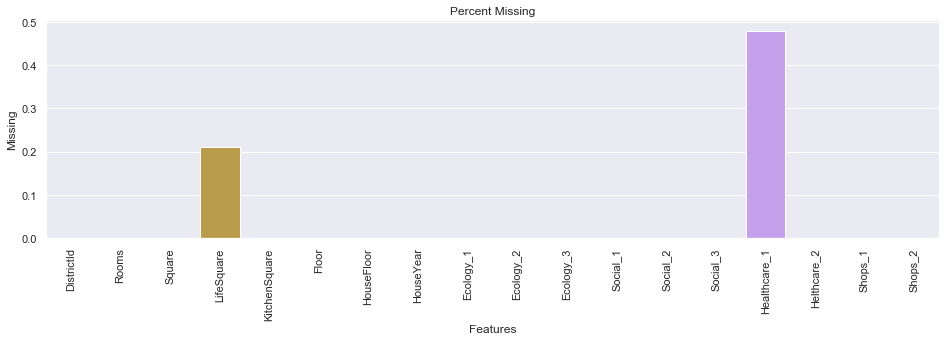

In [35]:
nan_analize(X)

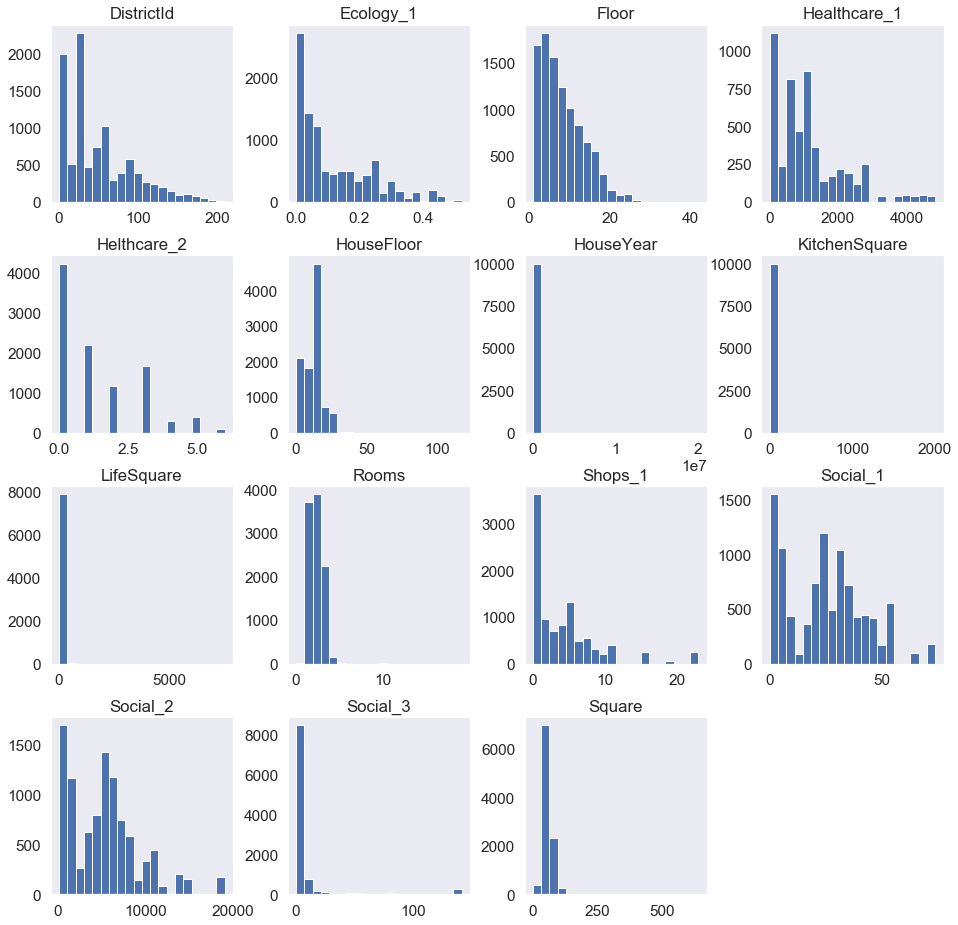

In [1234]:
X.hist(figsize=(16,16), bins=20, grid=False);

<Figure size 1152x576 with 0 Axes>

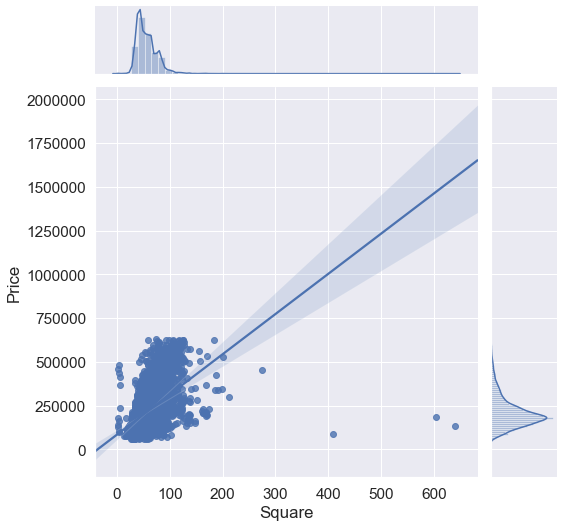

In [1147]:
plt.figure(figsize = (16, 8))

grid = sns.jointplot(X['Square'], y['Price'], kind='reg')
# plt.plot(np.arange(0, 8000, 100), np.arange(0, 8000, 100), color = 'red', linestyle='--')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

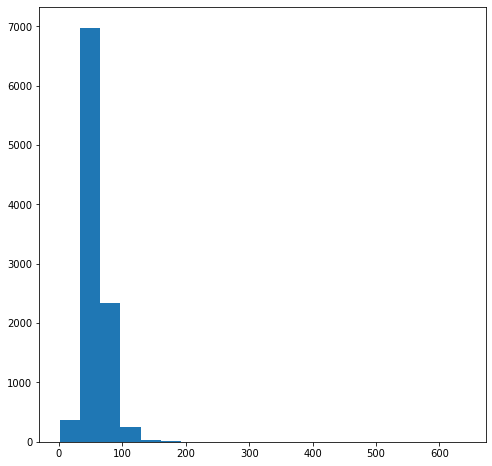

In [28]:
X['Square'].hist(figsize=(8,8), bins=20, grid=False);

<Figure size 1152x576 with 0 Axes>

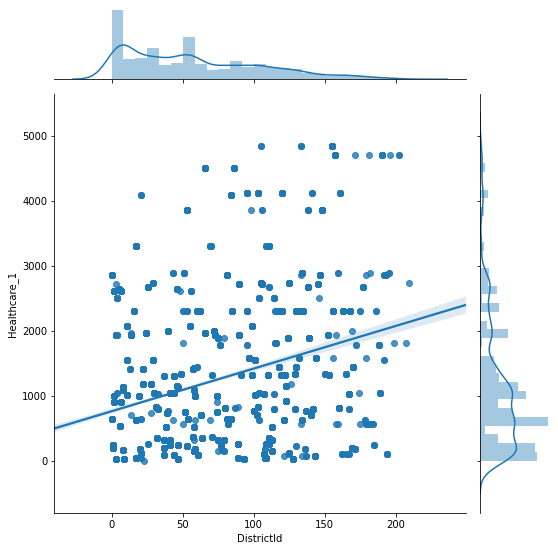

In [29]:
plt.figure(figsize = (16, 8))

grid = sns.jointplot(X['DistrictId'], X['Healthcare_1'], kind='reg')
# plt.plot(np.arange(0, 8000, 100), np.arange(0, 8000, 100), color = 'red', linestyle='--')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

<Figure size 1152x576 with 0 Axes>

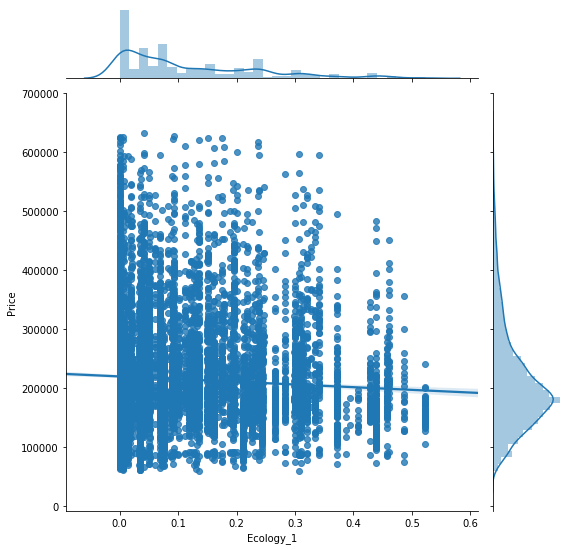

In [30]:
plt.figure(figsize = (16, 8))

grid = sns.jointplot(X['Ecology_1'], y['Price'], kind='reg')
# plt.plot(np.arange(0, 8000, 100), np.arange(0, 8000, 100), color = 'red', linestyle='--')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

<Figure size 1152x576 with 0 Axes>

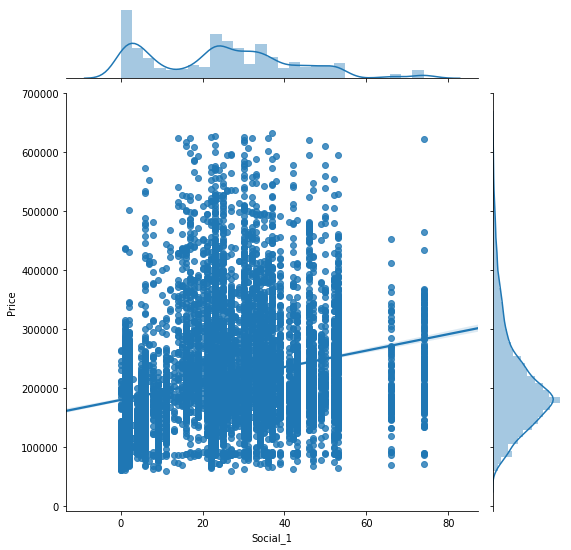

In [31]:
plt.figure(figsize = (16, 8))

grid = sns.jointplot(X['Social_1'], y['Price'], kind='reg')
# plt.plot(np.arange(0, 8000, 100), np.arange(0, 8000, 100), color = 'red', linestyle='--')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

<Figure size 1152x576 with 0 Axes>

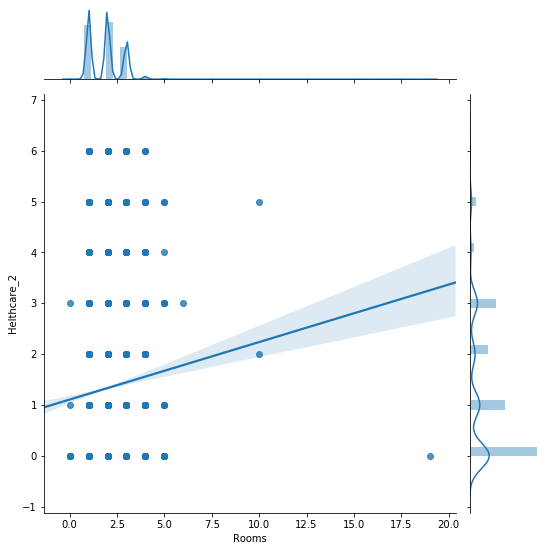

In [32]:
plt.figure(figsize = (16, 8))

grid = sns.jointplot(X['Rooms'], X['Helthcare_2'], kind='reg')
# plt.plot(np.arange(0, 8000, 100), np.arange(0, 8000, 100), color = 'red', linestyle='--')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

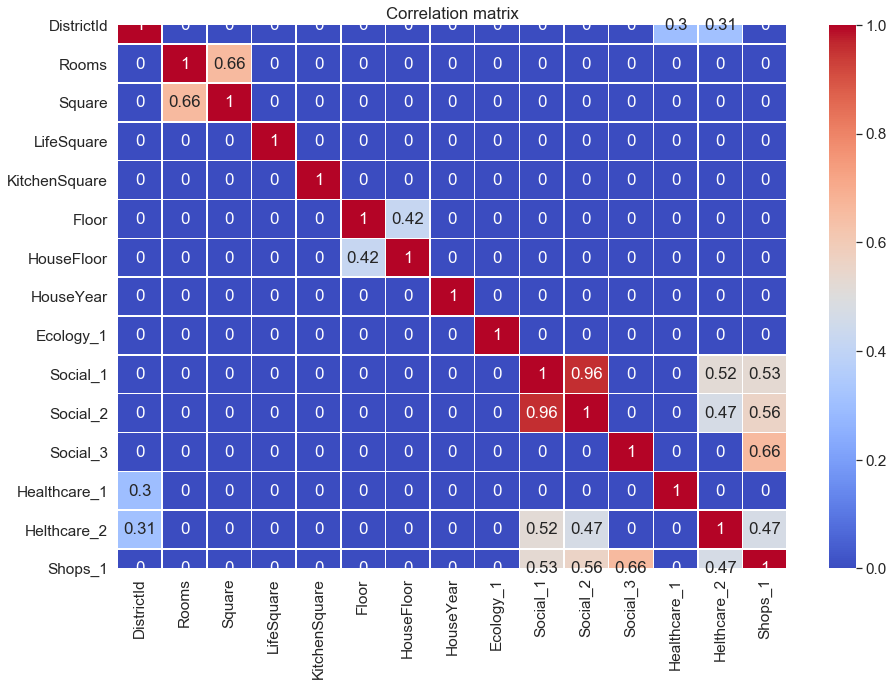

In [33]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = X.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0  # Проверьте, что будет если убрать маленькие корреляции

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

C:\Anaconda\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Anaconda\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


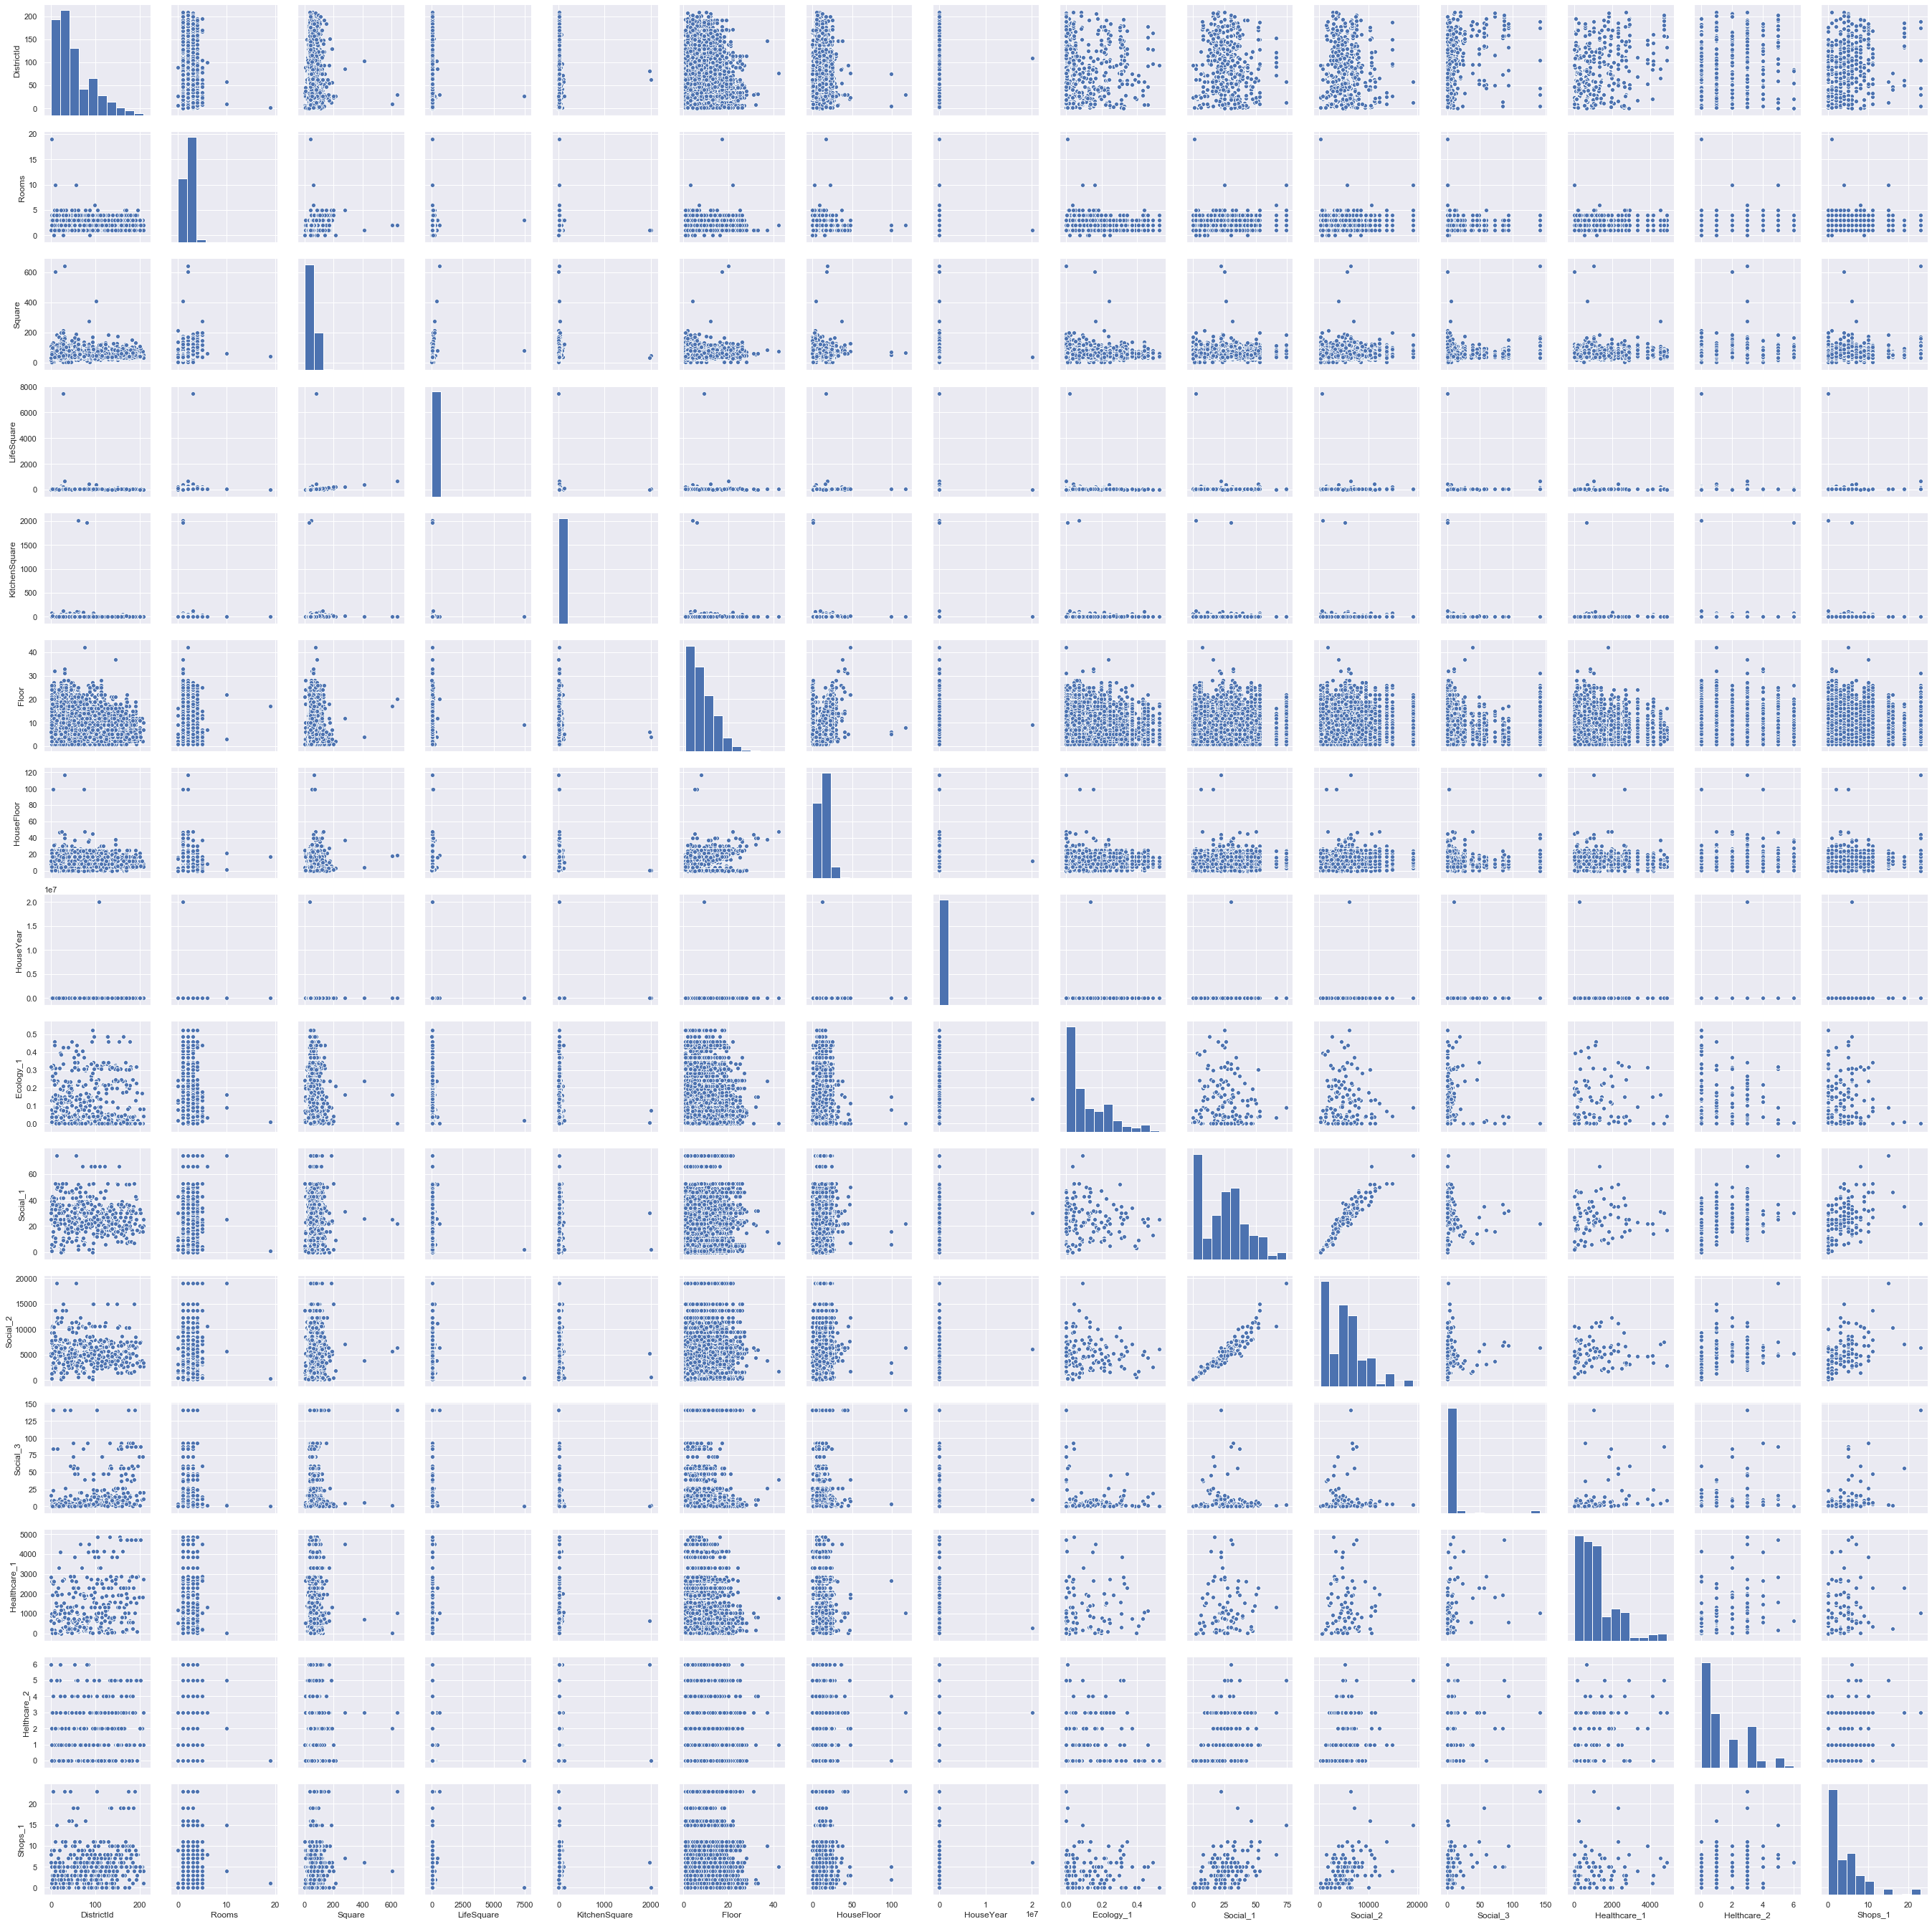

In [34]:
sns.set()
sns.pairplot(X, height = 2.5)
plt.show();